<a href="https://colab.research.google.com/github/superahxd/_project/blob/main/sec2/%EA%B5%90%EB%B3%B5%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> 학생수에 따른 적절한 교복 가격 찾기



In [ ]:
 !pip install pandas-profiling==2.7.1

In [ ]:
pip install category_encoders

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


#1) 데이터 선정 이유 및 문제 정의
이 데이터를 선정한 이유는 몇 학년의 학생수가 교복값에 미치는 영향이 가장 클까 궁금했기 때문입니다. 교복 값은 연속성 데이터이기 때문에 회귀 문제로 결정했습니다.

In [ ]:
import pandas as pd

list1 = ['/content/2018교복가격.csv', '/content/2019교복가격.csv', '/content/2020교복가격.csv',
         '/content/2018학생수.csv', '/content/2019학생수.csv', '/content/2020학생수.csv']
d = {}
for _, i in enumerate(list1):
    file_name = "df" + str(_)
    d[file_name] = pd.read_csv(i)

In [ ]:
cloth_18 = pd.DataFrame.from_dict(d['df0'])
cloth_19 = pd.DataFrame.from_dict(d['df1'])
cloth_20 = pd.DataFrame.from_dict(d['df2'])
people_18 = pd.DataFrame.from_dict(d['df3'])
people_19 = pd.DataFrame.from_dict(d['df4'])
people_20 = pd.DataFrame.from_dict(d['df5'])

In [ ]:
people_18.head(1)

,지역,학교명,학교급코드,1학년 학급수,1학년 학생수,1학년 학급당 학생수,2학년 학급수,2학년 학생수,2학년 학급당 학생수,3학년 학급수,3학년 학생수,3학년 학급당 학생수,특수학급 학급수,특수학급 학생수,특수학급 학급당 학생수,순회학급 학급수,순회학급 학생수,순회학급 학급당 학생수,학급수(계),학생수(계),학급당 학생수(계),교사수,수업교원 1인당 학생수
0,서울특별시 강남구,국립국악고등학교,4,5,151,30.2,5,144,28.8,5,142,28.4,0,0,0.0,0,0,0.0,15,437,29.1,39,11.2


In [ ]:
cloth_18.head(1)

,지역,학교명,학교급코드,동복(평균)가격,하복(평균)가격
0,서울특별시 강남구,국립국악고등학교,4,204000.0,83000.0


In [ ]:
#연도별 자료 합치기
y18 = pd.merge(people_18, cloth_18, how='outer', on=['지역','학교명','학교급코드'])
y19 = pd.merge(people_19, cloth_19, how='outer', on=['지역','학교명','학교급코드'])
y20 = pd.merge(people_20, cloth_20, how='outer', on=['지역','학교명','학교급코드'])

In [ ]:
#연도 칼럼 생성
y18['연도'] = 2018
y19['연도'] = 2019
y20['연도'] = 2020

In [ ]:
#자료 합치기
data = pd.concat([y18, y19, y20], ignore_index = True)

#2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

제가 세운 가설은 '1학년 수가 많을 수록 교복 값이 평균 이하일 확률이 높다.' 입니다. </br>
평가지표는 회귀분석의 평가지표인 mae와 R2를 사용할 것입니다.

In [ ]:
#데이터셋 나누기
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, train_size=0.80, test_size=0.20, random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)
train.shape, val.shape, test.shape

((10875, 26), (2719, 26), (3399, 26))

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train.columns

Index(['지역', '학교명', '학교급코드', '1학년 학급수', '1학년 학생수', '1학년 학급당 학생수', '2학년 학급수',
       '2학년 학생수', '2학년 학급당 학생수', '3학년 학급수', '3학년 학생수', '3학년 학급당 학생수',
       '특수학급 학급수', '특수학급 학생수', '특수학급 학급당 학생수', '순회학급 학급수', '순회학급 학생수',
       '순회학급 학급당 학생수', '학급수(계)', '학생수(계)', '학급당 학생수(계)', '교사수', '수업교원 1인당 학생수',
       '동복(평균)가격', '하복(평균)가격', '연도'],
      dtype='object')

3) EDA와 데이터 전처리
Feature Engineering, 노이즈 제거, 결측치 제거 혹은 대체

In [ ]:
import numpy as np
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""

    #카디널리티 높은 값 지우기
    df = df.drop(columns=['학교명','하복(평균)가격','지역','1학년 학급수','2학년 학급수', '1학년 학급당 학생수','2학년 학급당 학생수',
                          '3학년 학급당 학생수','3학년 학급수','학급수(계)', '학급당 학생수(계)','교사수', '수업교원 1인당 학생수' ])
    df = df.drop(columns=[ '특수학급 학급수', '특수학급 학생수', '특수학급 학급당 학생수', 
                          '순회학급 학급수', '순회학급 학생수','순회학급 학급당 학생수'])
    #결측치 채우기
    df['동복(평균)가격'].fillna(train['동복(평균)가격'].median(), inplace=True)

    # np.percentile 사용해 이상치 제거
    df = df[(df['동복(평균)가격'] >= np.percentile(df['동복(평균)가격'], 0.05)) & 
        (df['동복(평균)가격'] <= np.percentile(df['동복(평균)가격'], 99.5))]
  
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?</br>

>하복 가격 칼럼을 드랍함으로써 방지했습니다.</br>

이애현님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?</br>

>학생수와 학교 규모를 가지고 교복값을 판단할 때는 유용하나, 교복의 재질이나 디자인의 가격은 반영되지 않습니다.

1) 타겟은 동복의 가격입니다. 동복 가격의 형성 조건을 구하는 것이기 때문에 타겟을 동복 가격으로 정했습니다.

In [ ]:
#타겟 설정
target = '동복(평균)가격'
features = train.columns.drop([target])

In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

#Baseline

In [ ]:
train[target].mean()

189674.52149394472

In [ ]:
train.groupby('1학년 학생수')['동복(평균)가격'].mean()

1학년 학생수
0.0      201137.523810
1.0      200299.166667
2.0      201783.262295
3.0      194872.028986
4.0      201577.000000
             ...      
493.0    170000.000000
494.0    190500.000000
497.0    217480.000000
513.0    136000.000000
514.0    166000.000000
Name: 동복(평균)가격, Length: 465, dtype: float64

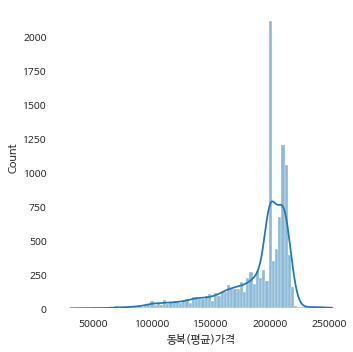

In [ ]:
import seaborn as sns

## displot, '동복(평균)가격'
%matplotlib inline
sns.displot(y_train, kde=True);
#심각한 negative skewed

#4) 머신러닝 방식 적용 및 교차검증
중요한 특성을 일부 가려내고 과적합을 방지하는 ridge모델을 사용했습니다.

In [ ]:
from category_encoders import TargetEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

alphas = [0.01, 0.05, 0.1, 0.2, 1.0, 10.0, 100.0]

pipe = make_pipeline(
   OrdinalEncoder()
    , SimpleImputer()
    , Ridge()
)

# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
    'simpleimputer__strategy': ['mean', 'median']
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.5s finished


In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred = clf.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

훈련 에러: 21861.29


In [ ]:
y_pred = clf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 21408.99


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)
model = search.best_estimator_

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean'}
MAE:  21881.902381688862


In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe = clf.best_estimator_

평가지표

In [ ]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

# MAE for test
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Val MAE: {mae:,.0f}원')
print(f'Val R2: {r2:,.3f}')

Val MAE: 21,409원
Val R2: 0.006


<AxesSubplot:>

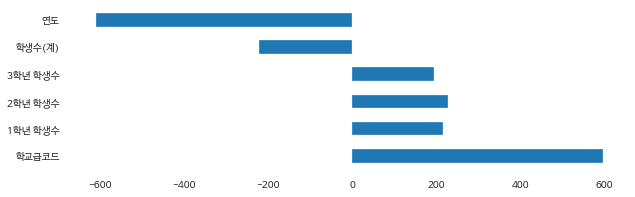

In [ ]:
coefficients = pipe.named_steps['ridge'].coef_
arry = pd.Series(coefficients, features)
plt.figure(figsize=(10,3))
arry.plot(kind='barh')

#XGBRegressor

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test)

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val), (X_test_encoded, y_test)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:173267	validation_1-rmse:173707	validation_2-rmse:171784
Multiple eval metrics have been passed: 'validation_2-rmse' will be used for early stopping.

Will train until validation_2-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:156469	validation_1-rmse:156894	validation_2-rmse:155024
[2]	validation_0-rmse:141405	validation_1-rmse:141812	validation_2-rmse:140007
[3]	validation_0-rmse:127911	validation_1-rmse:128298	validation_2-rmse:126558
[4]	validation_0-rmse:115832	validation_1-rmse:116195	validation_2-rmse:114530
[5]	validation_0-rmse:105033	validation_1-rmse:105372	validation_2-rmse:103791
[6]	validation_0-rmse:95393.2	validation_1-rmse:95703.9	validation_2-rmse:94212.7
[7]	validation_0-rmse:86802.3	validation_1-rmse:87090.1	validation_2-rmse:85694.2
[8]	validation_0-rmse:79161.5	validation_1-rmse:79428.4	validation_2-rmse:78131.2
[9]	validation_0-rmse:72380.8	validation_1-rmse:72621.2	validation_2-rmse:71443.2
[10]	validation_0-rmse:66380.7	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = boosting.predict(X_val_encoded)
mae = mean_absolute_error(y_val, y_pred)
print('R2:', r2_score(y_val, y_pred))
print(f'Val MAE: {mae:,.0f}원')

R2: 0.006390235241688913
Val MAE: 22,024원


In [ ]:
y_pred = boosting.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)
print('R^2', r2_score(y_test, y_pred))
print(f'test MAE: {mae:,.0f}원')
r2 = r2_score(y_test, y_pred)
print(f'test R2: {r2:,.3f}')

R^2 0.025695600276402386
Val MAE: 23,117원
Val R2: 0.026


5) 머신러닝 모델 해석

In [ ]:
pip install shap

In [ ]:
row = X_test.iloc[[3]]
row

,학교급코드,1학년 학생수,2학년 학생수,3학년 학생수,학생수(계),연도
6323,4,221.0,173.0,217.0,611.0,2019


In [ ]:
boosting.predict(row)

array([185747.62], dtype=float32)

In [ ]:
import shap
model = boosting
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
row = X_test.iloc[[221]]
model = boosting
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])

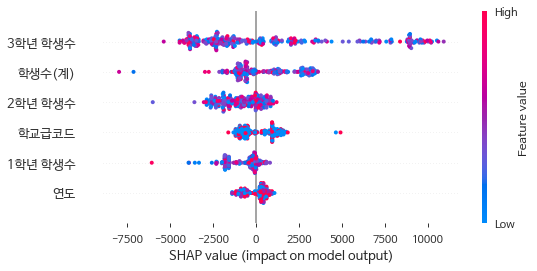

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

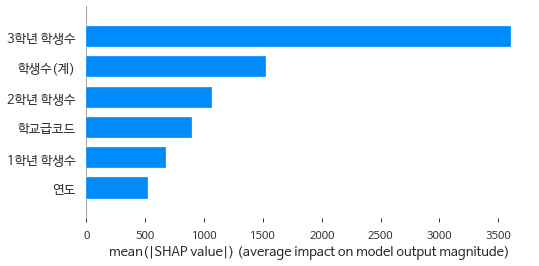

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")

모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?


아쉬웠던 점</br>

데이터 셋에 학생 수 외의 학교와 교복에 대한 좀 더 다양한 정보가 담겨 있으면 좋았을 것 같다. </br>

모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
>3학년 학생수를 가장 많이 사용했다.

어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?
>학생 수 외에 학교의 재정상황이나 예산, 교복 재질 등의 정보가 있었으면 더 좋았을 것 같다. 이런 정보는 공공 알리미에 올라오지 않으니 구하기가 힘들다.
